# General imports/paths

## Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix
import pickle
from shapely.geometry import Point
from shapely.geometry import LineString
import seaborn as sns
from scipy.stats.stats import pearsonr   

## Paths

In [2]:
data_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data'
list_animals = ['20211204/mouse_01_CA1','20211206/mouse_01_CA1','20211207/mouse_01_CA1']
path_registration_file = os.path.join(data_dir, 'cellRegistered_M1_CA1.mat')

## Functions

In [3]:
def loadAll(animal):
    
    global meta_spikes, df_dlc, mat_spikes, df_frames, dict_meta, reference_points, path_pickle, path_table, path_mat_spikes, cur_dir
    
    cur_dir = os.path.join(data_dir, animal)
    path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
    path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')    
    path_pickle = os.path.join(cur_dir, 'pickle')
    
    with open(os.path.join(path_pickle, 'meta_spikes.pck'), 'rb') as f:
        meta_spikes = pickle.load(f)
    with open(os.path.join(path_pickle, 'df_dlc_projections.pck'), 'rb') as f:
        df_dlc = pickle.load(f)
    with open(os.path.join(path_pickle, 'mat_spikes.pck'), 'rb') as f:
        mat_spikes = pickle.load(f)
    with open(os.path.join(path_pickle, 'df_frames.pck'), 'rb') as f:
        df_frames = pickle.load(f)
    with open(os.path.join(path_pickle, 'dict_meta.pck'), 'rb') as f:
        dict_meta = pickle.load(f)
    with open(os.path.join(path_pickle, 'reference_points.pck'), 'rb') as f:
        reference_points = pickle.load(f)
        
    df_dlc_axis = df_dlc[['closest_arm', 'projection', 'environment']]
    meta_spikes = meta_spikes.join(df_dlc_axis, on = 'behavioral_frame')
    

# Loading registration

In [4]:
with h5py.File(path_registration_file, 'r') as f:
    mat_reg = np.array(f['cell_registered_struct']['cell_to_index_map'])

# Functions

In [5]:
list_vect_rate = list()

for i,animal in enumerate(list_animals):
    
    loadAll(animal)
    
    for env in ['t_maze', 'y_maze', 'open_field']:
        
        cur_meta = meta_spikes.query('environment == @env')
        vect_rate = np.zeros(mat_reg.shape[1])
        
        for j,r in enumerate(mat_reg.T):
            
            cur_cell = int(r[i]-1)
            
            if cur_cell == -1:
                continue
                
            val = np.sum(mat_spikes[cur_meta.index, cur_cell] > 0)  
            vect_rate[j] = val
            
        list_vect_rate.append(vect_rate)

## Across registration

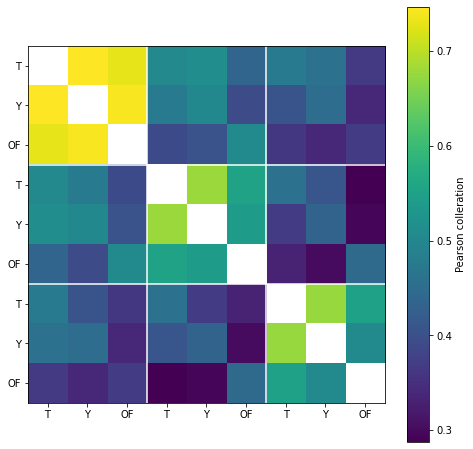

In [6]:
path_plot = os.path.join(data_dir, '..', 'plots', 'correlation_matrix')
os.makedirs(path_plot, exist_ok=True)

plt.figure(figsize = (8,8))
mat_corr = np.zeros(shape = (len(list_vect_rate), len(list_vect_rate)))
for i in range(0,mat_corr.shape[0]):
    for j in range(0,mat_corr.shape[0]):
        if i == j:
            mat_corr[i,j] = None
        else:
            mat_corr[i,j] = pearsonr(list_vect_rate[i], list_vect_rate[j])[0]
ax = plt.imshow(mat_corr[0:,0:])
plt.colorbar(ax, label = 'Pearson colleration')
_ = plt.xticks(range(9), labels = ['T', 'Y', 'OF', 'T', 'Y', 'OF','T', 'Y', 'OF'])
_ = plt.yticks(range(9), labels = ['T', 'Y', 'OF', 'T', 'Y', 'OF','T', 'Y', 'OF'])
plt.axhline(2.5, c = 'w')
plt.axhline(5.5, c = 'w')
plt.axvline(2.5, c = 'w')
plt.axvline(5.5, c = 'w')
plt.savefig(os.path.join(path_plot, 'correlation_all_cells.png'), dpi = 300)

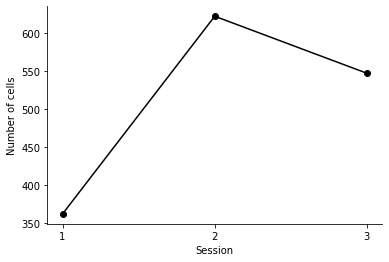

In [7]:
n_cells = list()
for animal in list_animals:
    loadAll(animal)
    n_cells.append(mat_spikes.shape[1])
plt.plot(range(1,4), n_cells, c = 'k', marker = 'o')
plt.ylabel('Number of cells')
plt.xlabel('Session')
plt.xticks([1,2,3])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(os.path.join(path_plot, 'number_cells.png'), dpi = 300)

## Only valid cells (expressed very day)

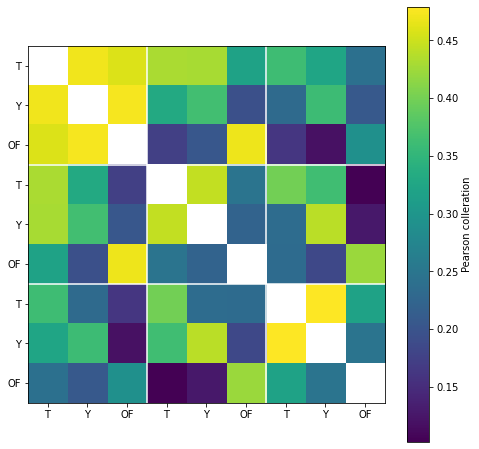

In [8]:
is_cell_valid = np.array(np.zeros(len(vect_rate), dtype = 'bool'))

for i,r in enumerate(mat_reg.T):
    if all(r != 0):
        is_cell_valid[i] = True
        
plt.figure(figsize = (8,8))
mat_corr = np.zeros(shape = (len(list_vect_rate), len(list_vect_rate)))
for i in range(0,mat_corr.shape[0]):
    for j in range(0,mat_corr.shape[0]):
        if i == j:
            mat_corr[i,j] = None
        else:
            mat_corr[i,j] = pearsonr(list_vect_rate[i][is_cell_valid], list_vect_rate[j][is_cell_valid])[0]
ax = plt.imshow(mat_corr[0:,0:])
plt.colorbar(ax, label = 'Pearson colleration')
_ = plt.xticks(range(9), labels = ['T', 'Y', 'OF', 'T', 'Y', 'OF','T', 'Y', 'OF'])
_ = plt.yticks(range(9), labels = ['T', 'Y', 'OF', 'T', 'Y', 'OF','T', 'Y', 'OF'])
plt.axhline(2.5, c = 'w')
plt.axhline(5.5, c = 'w')
plt.axvline(2.5, c = 'w')
plt.axvline(5.5, c = 'w')
plt.savefig(os.path.join(path_plot, 'correlation_all_days.png'), dpi = 300)